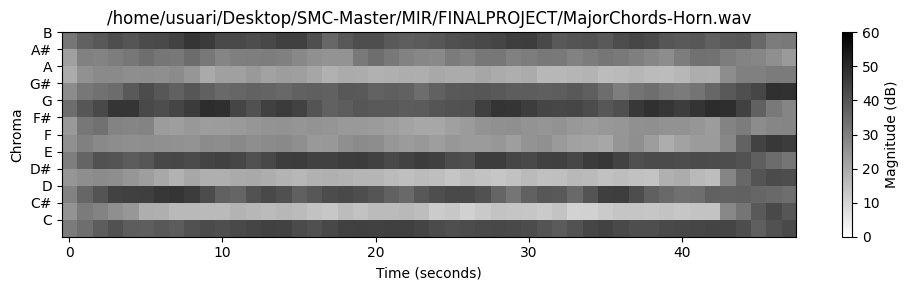

(12, 623)


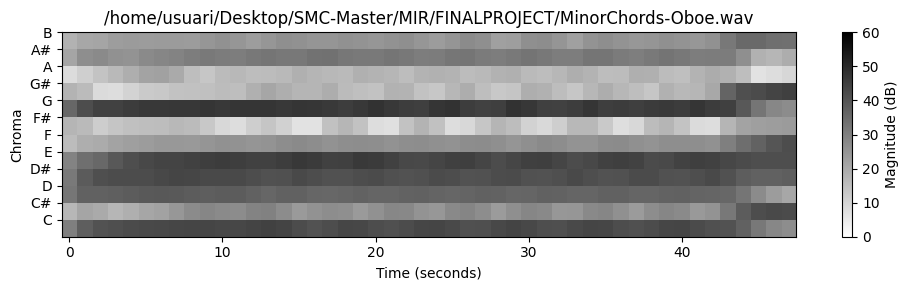

(12, 619)


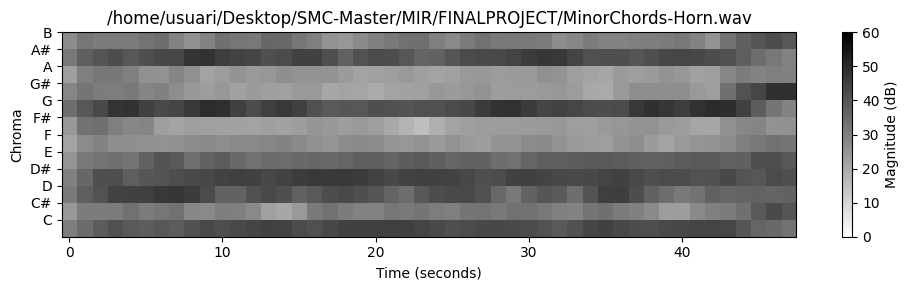

(12, 622)


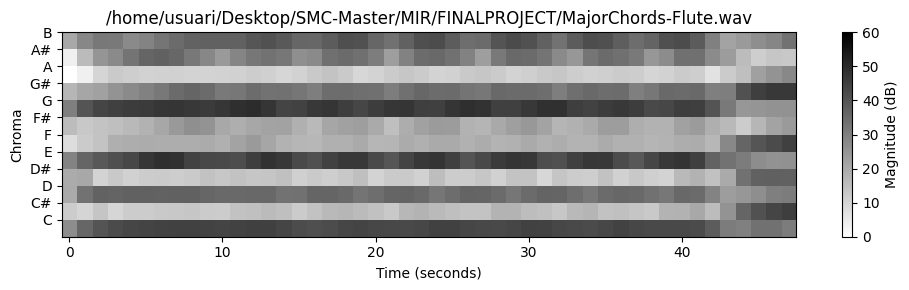

(12, 620)


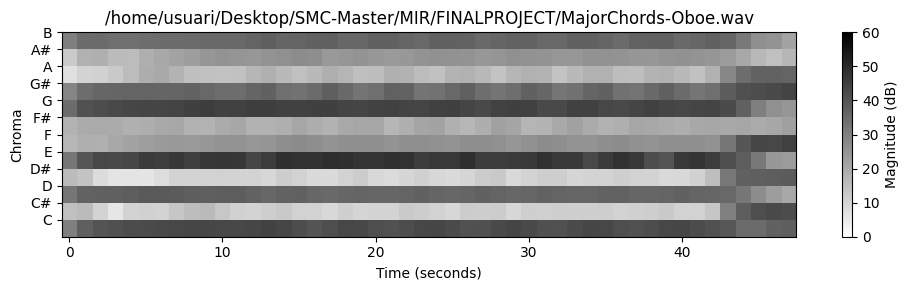

(12, 619)


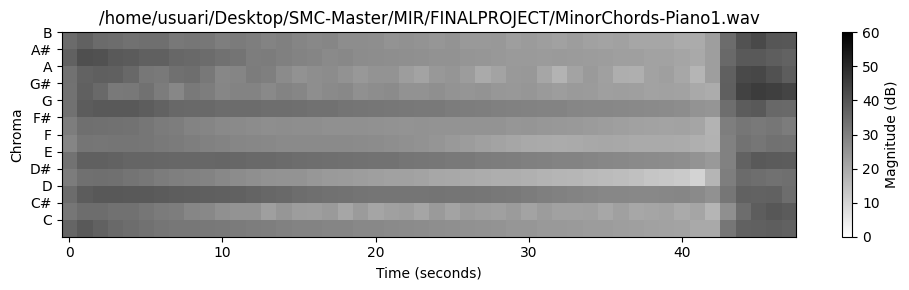

(12, 597)


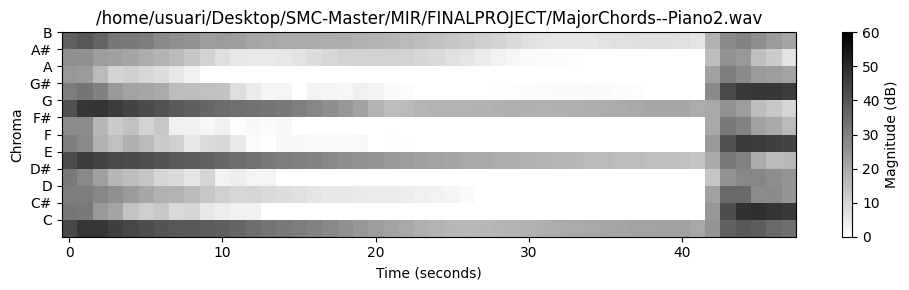

(12, 591)


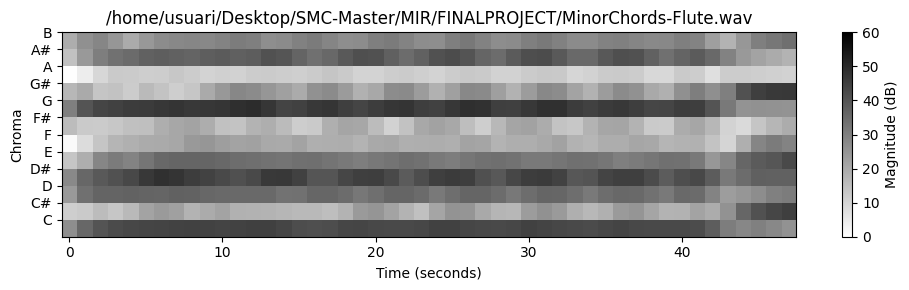

(12, 621)


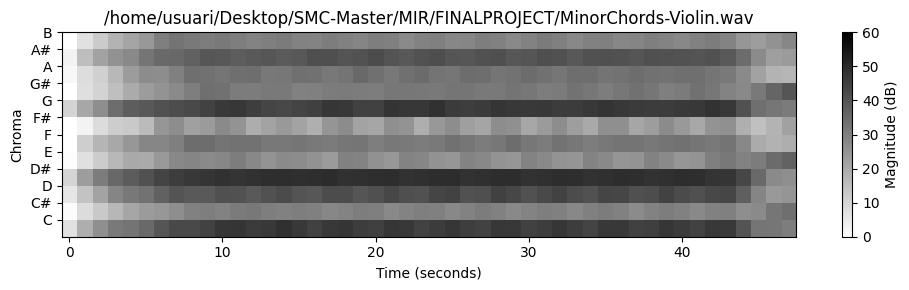

(12, 618)


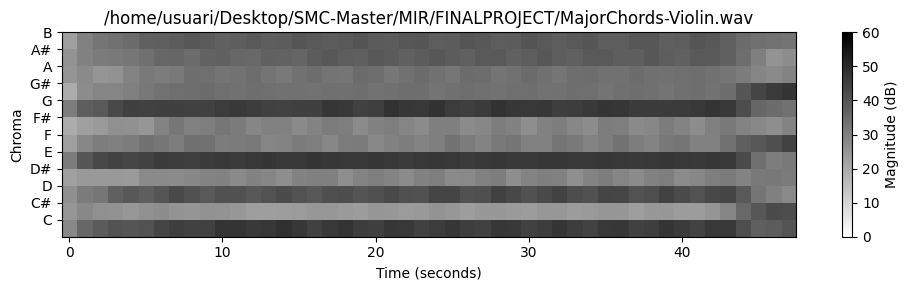

(12, 615)


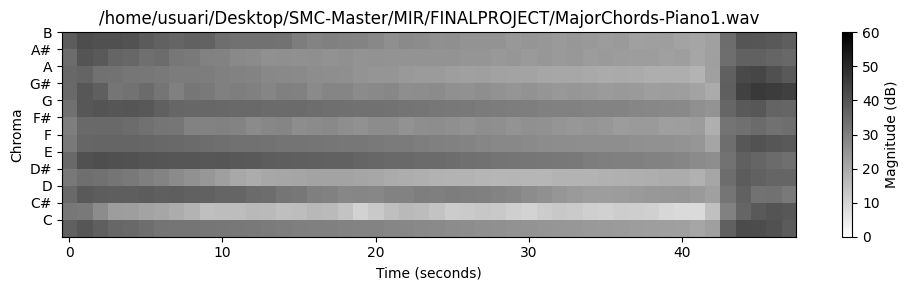

(12, 601)


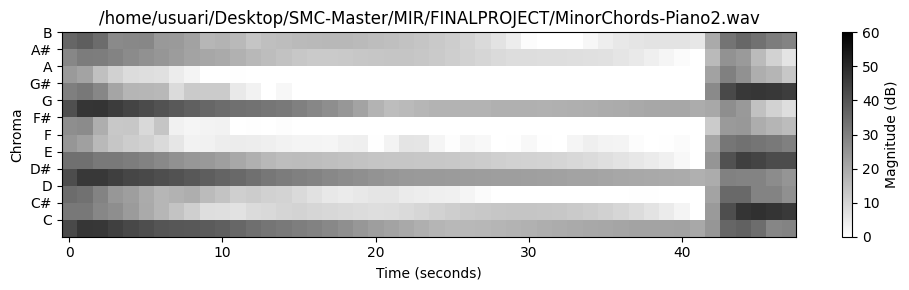

(12, 590)


In [209]:
import json
import numpy as np
import matplotlib.pyplot as plt
eps = np.finfo(float).eps

with open("chromagrams.json", "r") as f:
    chromagrams = json.load(f)

### THE CHORD CHANGES EVERY 43 FRAMES APPROXIMATELY

allchrom = []
for key in chromagrams:
    chroma = np.array(chromagrams[key])

    fig = plt.figure(figsize=(10, 3))
    chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 
    'F#', 'G', 'G#', 'A', 'A#', 'B']
    plt.imshow(10 * np.log10(eps + chroma)[:, :48], origin='lower', aspect='auto', cmap='gray_r')
    plt.clim([0, 60])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Chroma')
    cbar = plt.colorbar()
    cbar.set_label('Magnitude (dB)')
    plt.yticks(np.arange(12) + 0.5, chroma_label)
    plt.title(key)
    plt.tight_layout()
    plt.show()
    print(chroma.shape)

    # Average chroma features through all the frames of each event
    chroma = np.array([np.mean(chroma[:, i * 43 : (i + 1) * 43], axis=1) for i in range(12)]).T

    allchrom.append(chroma)

### Some functions

In [143]:
import numpy as np
import librosa

def build_chord_templates():
    """
    Build a dictionary of chord templates for major and minor triads
    across all roots (12 semitones).
    
    Returns:
        chord_templates (dict): keys = chord name (str),
                                values = 12D numpy array
    """
    # For convenience, we index pitch classes as:
    # C=0, C#=1, D=2, D#=3, E=4, F=5,
    # F#=6, G=7, G#=8, A=9, A#=10, B=11
    # major triad = [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0] (root, major 3rd, perfect 5th)
    # minor triad = [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0] but with a flat 3rd

    # base major triad starting at C
    major_base = np.zeros(12)
    major_base[0] = 1   # root
    major_base[4] = 1   # major 3rd
    major_base[7] = 1   # perfect 5th
    
    # base minor triad starting at C
    minor_base = np.zeros(12)
    minor_base[0] = 1   # root
    minor_base[3] = 1   # minor 3rd
    minor_base[7] = 1   # perfect 5th

    chord_templates = {}
    note_names = ['C', 'C#', 'D', 'D#', 'E', 
                  'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # Construct major/minor templates for all 12 possible roots
    for root in range(12):
        # Rotate the base pattern by 'root' semitones
        major_pattern = np.roll(major_base, root)
        minor_pattern = np.roll(minor_base, root)

        # Name the chord e.g. "C Maj", "C# Maj", ... "C Min", ...
        chord_templates[f"{note_names[root]}_maj"] = major_pattern
        chord_templates[f"{note_names[root]}_min"] = minor_pattern
    
    return chord_templates


def chord_likelihoods_from_chroma(chroma, chord_templates):
    """
    Given a chromagram and a set of chord templates, compute
    the chord likelihood for each time frame.
    
    Args:
        chroma (np.ndarray): 12 x T matrix
        chord_templates (dict): chord name -> 12D numpy array

    Returns:
        chord_likelihoods (np.ndarray): shape (num_chords, T), 
                                        each entry is the dot product (or similarity) 
                                        between the chord template and the frame’s chroma
        chords (list of str): list of chord names matching the rows of chord_likelihoods
    """
    chord_names = list(chord_templates.keys())
    templates = np.array(list(chord_templates.values()))  # shape = (num_chords, 12)
    
    # Normalize templates if desired
    # (Optionally you can also normalize each column of the chroma prior to dot product.)
    # For example:
    # templates /= np.linalg.norm(templates, axis=1, keepdims=True) + 1e-7
    
    # Dot product:
    # For each time frame, we do (templates * chroma_frame).sum(axis=1)
    # We’ll vectorize it by performing matrix multiplication:
    # chord_likelihoods = templates @ chroma_frame
    # Here we want (num_chords, 12) x (12, T) -> (num_chords, T)
    chord_likelihoods = templates.dot(chroma)
    
    return chord_likelihoods, chord_names


def get_best_chord_each_frame(chord_likelihoods, chord_names):
    """
    From the chord likelihood matrix, pick the chord with the highest
    likelihood in each frame.
    
    Args:
        chord_likelihoods (np.ndarray): shape (num_chords, T)
        chord_names (list of str): list of chord names in the same order as chord_likelihoods

    Returns:
        best_chords (list of str): chord label for each frame
    """
    # Argmax over chord dimension (axis=0)
    best_indices = np.argmax(chord_likelihoods, axis=0)
    best_chords = [chord_names[i] for i in best_indices]
    return best_chords



### Scaling

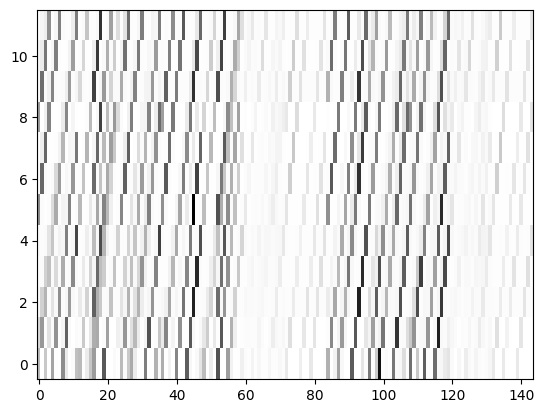

In [145]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

chroma_means = np.vstack(allchrom)
scaler = StandardScaler()
chroma_means = scaler.fit_transform(chroma_means)
chroma_means = pd.DataFrame(chroma_means)

plt.imshow(chroma_means.T, origin='lower', aspect='auto', cmap='gray_r')


### True labels

In [146]:
major_chords = ['C_maj', 'C#_maj', 'D_maj', 'D#_maj', 'E_maj', 'F_maj', 'F#_maj', 'G_maj', 'G#_maj', 'A_maj', 'A#_maj', 'B_maj']
minor_chords = ['C_min', 'C#_min', 'D_min', 'D#_min', 'E_min', 'F_min', 'F#_min', 'G_min', 'G#_min', 'A_min', 'A#_min', 'B_min']

true_labels = []
for key in chromagrams:
    if "Major" in key:
        true_labels.append(major_chords)
    else:
        true_labels.append(minor_chords)

true_labels = np.hstack(true_labels)

### Chord templates

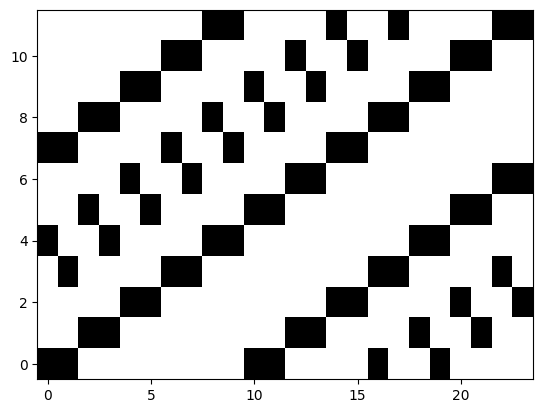

In [151]:
chord_templates = build_chord_templates()
templates = np.array(list(chord_templates.values()))
plt.imshow(templates.T, origin='lower', aspect='auto', cmap='gray_r')
template_labels = list(chord_templates.keys())

### K-means

K-means clustering using the chroma features. The templates are shown as crosses.

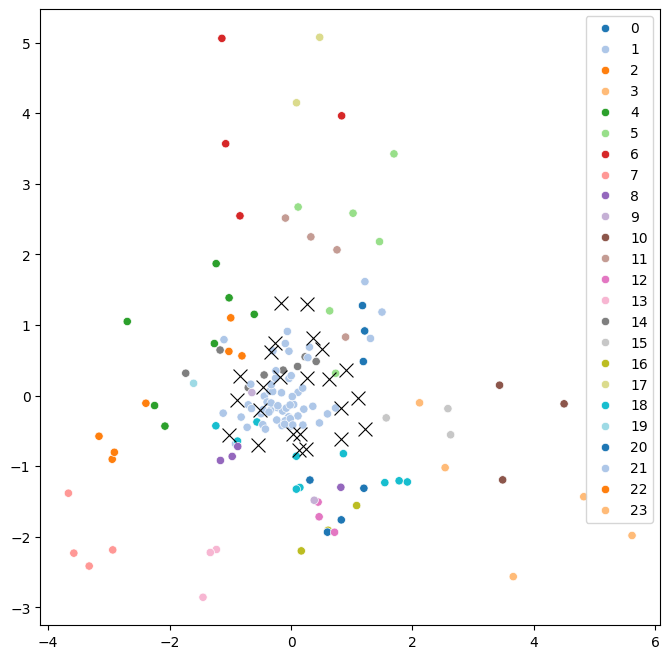

In [206]:
n_clusters = 24

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=n_clusters, random_state=123)
clusters = kmeans.fit_predict(chroma_means)

# Plot the cluster assignments
pca = PCA()
coords = pca.fit_transform(chroma_means)
template_coords = pca.transform(templates)

def plot_clusters(coords, template_coords, clusters):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=clusters, palette='tab20')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.scatterplot(x=template_coords[:, 0], y=template_coords[:, 1], color='black', s=100, marker='x')
    plt.show()

plot_clusters(coords, template_coords, clusters)



### HDBSCAN

/home/angel/anaconda3/envs/valerio/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/angel/anaconda3/envs/valerio/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


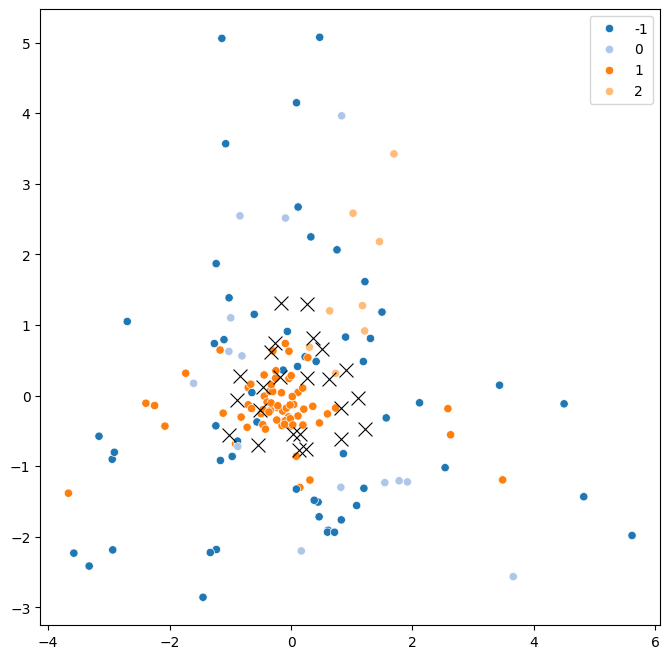

In [158]:
from hdbscan import HDBSCAN
dbscan = HDBSCAN(metric='cosine', algorithm='generic')
clusters = dbscan.fit_predict(chroma_means)

# Plot the cluster assignments
plot_clusters(coords, template_coords, clusters)

### Interactive TSNE

In [205]:
from faerun import Faerun
f = Faerun(clear_color="#111111", view="front", coords=False)

coords = TSNE().fit_transform(chroma_means)

cat_labels, chord_data = Faerun.create_categories(true_labels)

labels = list()

for i in range(len(chord_data)):
    labels.append(f"{true_labels[i]}_{chord_data[i]}")

f.add_scatter(
    "embeddings",
    {
        "x": coords[:, 0], 
        "y": coords[:, 1], 
        "c": [chord_data, clusters],
        "labels": labels,
    },
    colormap="tab20",
    shader="smoothCircle",
    point_scale=10,
    max_point_size=10,
    has_legend=[True, True],
    legend_labels=cat_labels,
    categorical=[True, True],
    series_title=["True class", "Cluster"],
    #selected_labels=["True class", "Cluster"],
    label_index=0,
    title_index=0
)

f.plot("PCA_Kmeans", template="default")

/home/angel/SMC/mir/chordclustering/PCA_Kmeans.html